# Andres Graterol - 4031393 - Fall 22
# Homework 3 Question 2 

## Generate The Data

In [27]:
# Import our libraries
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import norm

In [28]:
# Set up a gaussian prior
a = 1/2

m0 = np.transpose(np.zeros(2))
s0 = a*np.identity(2)

prior = multivariate_normal(mean=m0, cov=s0)

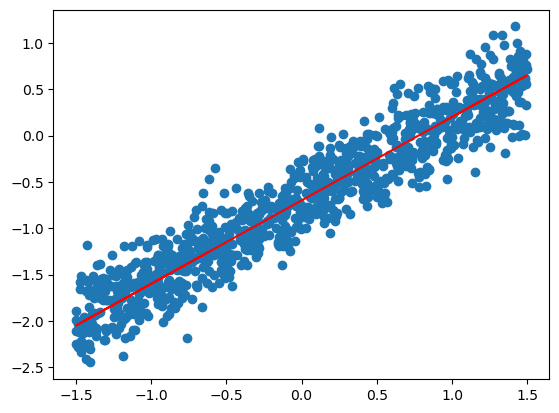

In [29]:
# Variables
N = 1000
variance = 0.25

# Intercept
w0 = -0.7
# slope
w1 = 0.9

# Generating N data points uniform in the interval [-3/2, 3/2]
data_points = np.random.uniform(low = (-3/2), high = (3/2), size = (N,))

noise = np.random.normal(0, variance, len(data_points))

linear_model = w0 + w1*data_points

targets = linear_model + noise

plt.plot(data_points, linear_model, 'red')
plt.scatter(data_points, targets)

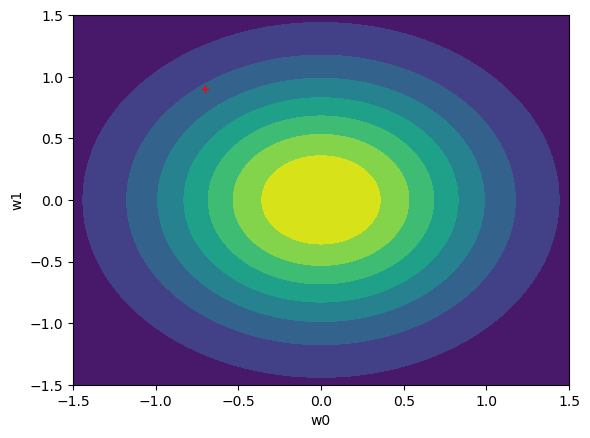

In [30]:
# Plot the assumed multivariate gaussian prior
X = np.linspace(-3/2, 3/2, N)
Y = np.linspace(-3/2, 3/2, N)
X, Y = np.meshgrid(X, Y)
pos = np.dstack((X, Y))
Z = prior.pdf(pos)

plt.xlabel("w0")
plt.ylabel("w1")
plt.plot(w0, w1, 'r+')
plt.contourf(X, Y, Z)
plt.show()

## Posterior Update

In [31]:
# Function to compute the design matrix
def compute_design_matrix(input_data):
    matrix = []
    for x in input_data:
        matrix.append([0, x])

    matrix = np.array(matrix)
    
    return matrix

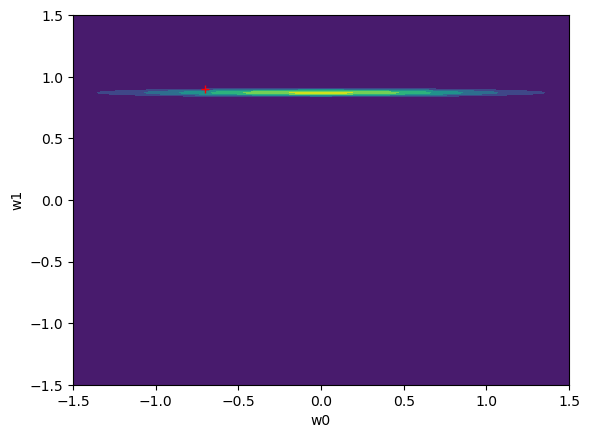

In [32]:
# Plot the posterior of the parameters given all the data x, t

# Obtain the design matrix 
phi = compute_design_matrix(data_points)

Sn = np.linalg.inv(np.linalg.inv(s0) + ((1/variance)*(np.matmul(np.transpose(phi), phi))))
Mn = np.matmul(Sn, (np.matmul(np.linalg.inv(s0), m0) + ((1/variance)*np.matmul(np.transpose(phi), targets))))

total_posterior = multivariate_normal(mean=Mn, cov=Sn)

Z = total_posterior.pdf(pos)

plt.xlabel("w0")
plt.ylabel("w1")
plt.plot(w0, w1, 'r+')
plt.contourf(X, Y, Z)
plt.show()

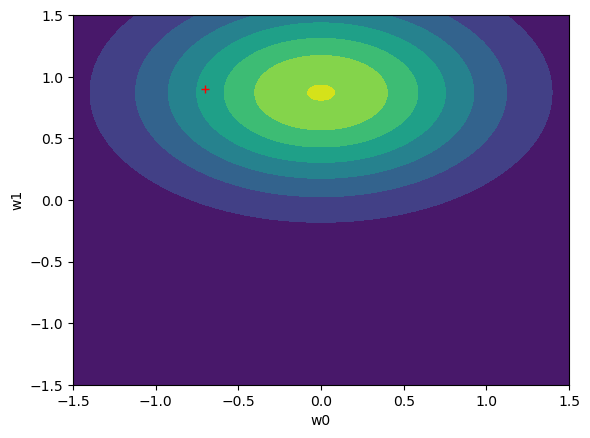

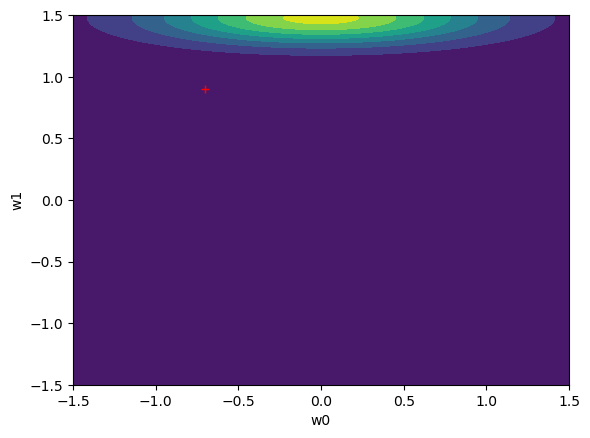

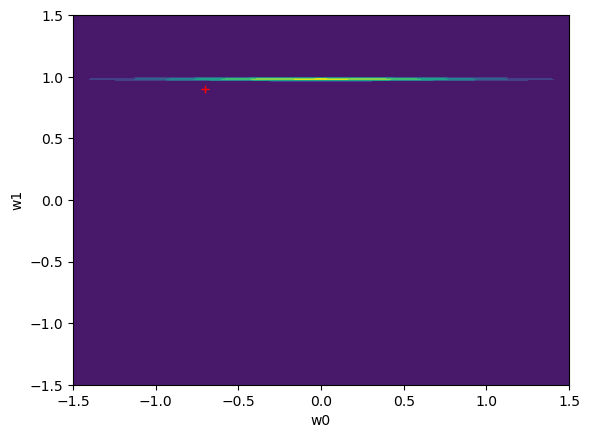

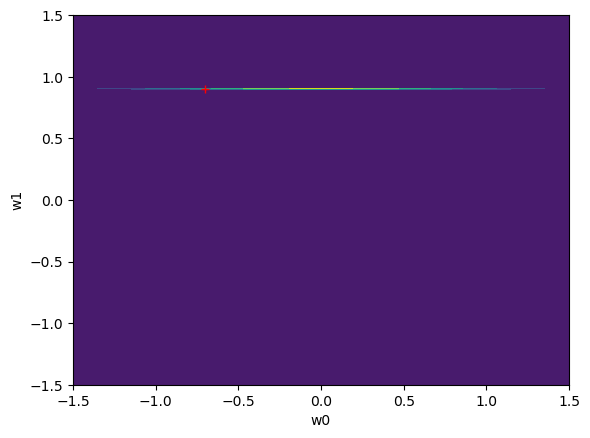

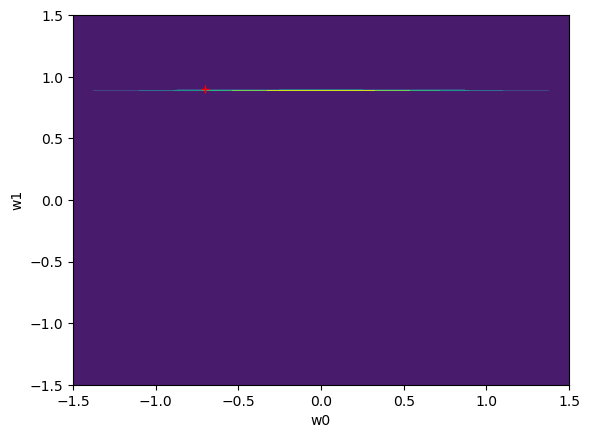

In [33]:
# Pass in data: (x,t) and the mean and variance of the prior
def update_posterior(data_points, targets, m0, s0):  
    input_list = []
    target_list = []
    target_list = np.array(target_list)
    # Iterate through every point
    for i in range(N):
        
        input_list.append(data_points[i])
        phi = compute_design_matrix(input_list)
        
        target_list = np.append(target_list, targets[i])
        
        # Find the posterior covariance and the mean with the help of likelihood and prior information
        posterior_covariance = np.linalg.inv(np.linalg.inv(s0) + (1/variance)*np.matmul(np.transpose(phi), phi)) 
        posterior_mean = np.matmul(posterior_covariance, (np.matmul(np.linalg.inv(s0), m0) + (1/variance)*np.matmul(np.transpose(phi), target_list)))
        
        # Plot the contour after seeing 1, 5, 100, 500, and 1000 data points
        if (i == 0 or i == 4 or i == 99 or i == 499 or i == 999):
            posterior = multivariate_normal(mean=posterior_mean, cov=posterior_covariance)
            Z = posterior.pdf(pos)

            plt.xlabel("w0")
            plt.ylabel("w1")
            plt.plot(w0, w1, 'r+')
            plt.contourf(X, Y, Z)
            plt.show()
    
        # Update the posterior to become the new prior
        s0 = posterior_covariance
        m0 = posterior_mean

# Set up prior information again just in case
a = 1/2
m0 = np.transpose(np.zeros(2))

s0 = a*np.identity(2)        
update_posterior(data_points, targets, m0, s0)

## Predictive Distribution

In [34]:
def compute_predictive_dist(point, Mn, Sn, variance):

    phi_x = [1, point]
    
    predictive_mean = np.matmul(np.transpose(phi_x), Mn)
    predictive_variance = np.matmul(np.matmul(np.transpose(phi_x), Sn), phi_x) + variance
    
    predictive_dist = norm(predictive_mean, predictive_variance)
    
    return predictive_dist

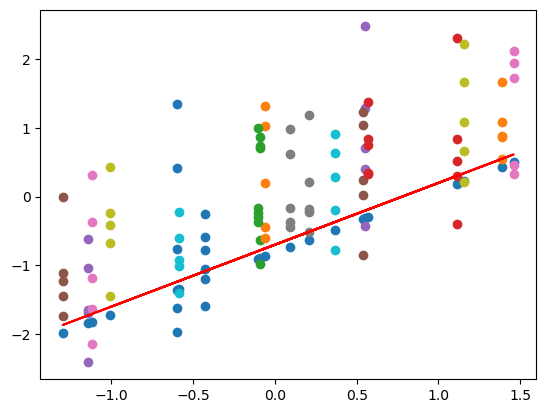

In [35]:
N = 1000
input_data = np.random.uniform(low=(-3/2), high=(3/2), size=(N,))
linear_model = w0 + w1*input_data
noise = np.random.normal(0, variance)
targets = linear_model + noise

# Compute the design_matrix 
phi = compute_design_matrix(input_data)

Sn = np.linalg.inv(np.linalg.inv(s0) + (1/variance)*(np.matmul(np.transpose(phi), phi)))
Mn = np.matmul(Sn, (np.matmul(np.linalg.inv(s0), m0) + (1/variance)*(np.matmul(np.transpose(phi), targets))))

# Generate test features, plot the input data, true labels, and some sample predictions
N = 20
test_features = np.linspace((-3/2), (3/2), N)
test_features = np.random.uniform(low = (-3/2), high = (3/2), size = (N,))
linear_model = w0 + w1*test_features
noise = np.random.normal(0, variance)
true_labels = linear_model + noise

samples_list = []

for i in range(N):
    predictive_dist = compute_predictive_dist(test_features[i], Mn, Sn, variance)
    
    # Try three samples for each point 
    samples = predictive_dist.rvs(5)
    samples_list.append(samples)
    #plt.scatter(test_features, samples_list[i])
    
samples_list = np.array(samples_list)

samples_list = samples_list.squeeze()

plt.plot(test_features, linear_model, 'red')
plt.scatter(test_features, true_labels)   

for xe, ye in zip(test_features, samples_list):
    plt.scatter([xe] * len(ye), ye)

Above we can see the linear model in red, the input features represented by the x-axis, the true values represented in blue on the y-axis, and 5 sample points taken from the gaussian predictive distribution of the true values